The purpose of this notebook is to QA the posterior probability results returned from the Looker visualization in python.  

Resources:
- http://christianherta.de/lehre/dataScience/bayesian/introduction_into_bayesian_inference_with_pymc.slides.php
- https://towardsdatascience.com/a-b-testing-with-probabilistic-programming-and-pymc3-part-i-7ae52d45bc41
- https://github.com/pymc-devs/pymc
- http://docs.pymc.io/api/distributions/discrete.html#pymc3.distributions.discrete.Binomial




In [1]:
import pymc3 as pm
import numpy as np
import arviz as az

/var/folders/1r/_qv5n71d6133d56_rx4zzq580000gn/T/ipykernel_12707/110112713.py:16: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(100000, step=step)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [campaign_2]
>Metropolis: [campaign_1]
/usr/local/lib/python3.9/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),


/usr/local/lib/python3.9/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/usr/local/lib/python3.9/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/usr/local/lib/python3.9/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
Sampling 4 chains for 1_000 tune and 100_000 draw iterations (4_000 + 400_000 draws total) took 61 seconds.
The number of effective samples is smaller than 25% for some parameters.


Probability that campaign_2 is better: 41.68105263157894.


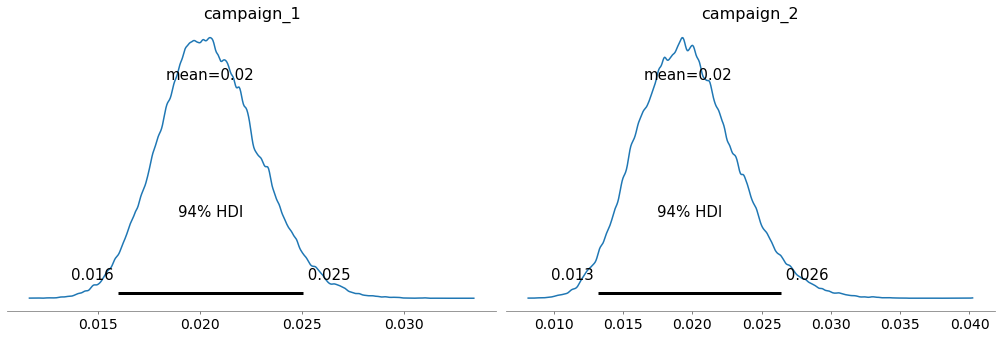

In [2]:
def create_bayesian_ab_test_model(
    variant_name_1, visitors_1, conversions_1, 
    variant_name_2, visitors_2, conversions_2, 
    prior_alpha=1, prior_beta=1):
    
    with pm.Model() as model:
        # priors
        prior1 = pm.Beta(variant_name_1, prior_alpha, prior_beta)
        prior2 = pm.Beta(variant_name_2, prior_alpha, prior_beta)

        observations_1 = pm.Binomial(variant_name_1 + '_obs', p=prior1, n=visitors_1, observed=conversions_1)
        observations_2 = pm.Binomial(variant_name_2 + '_obs', p=prior2, n=visitors_2, observed=conversions_2)
        
        #MCMC algorithm 
        step=pm.Metropolis()
        trace = pm.sample(100000, step=step)
        trace = trace[5000:]
        az.plot_posterior(trace)
         
        variant1_samples = trace[variant_name_1]
        variant2_samples = trace[variant_name_2]
        print(f'Probability that {variant_name_2} is better: {(variant2_samples > variant1_samples).mean() * 100}.')
        
    return trace
        
test_1 = create_bayesian_ab_test_model(
    'campaign_1', 3417, 69,
    'campaign_2', 1525, 29
)

In [29]:
def print_credible_intervals(trace, variant_name_1, variant_name_2, interval=90):
    # 90% credible intervals for test 1
    # get the 5th and 95th percentiles
    lower = (100 - interval) / 2
    upper = 100 - lower
    print('{}% CI for {}: ({}, {})'.format(
        interval,
        variant_name_1,
        np.percentile(trace[variant_name_1], lower),
        np.percentile(trace[variant_name_1], upper)
    ))
    print('{}% CI for {}: ({}, {})'.format(
        interval,
        variant_name_2,
        np.percentile(trace[variant_name_2], lower),
        np.percentile(trace[variant_name_2], upper)
    ))
    
print_credible_intervals(test_1, 'campaign_1', 'campaign_2')

90% CI for campaign_1: (0.016645311247557717, 0.02462505528969379)
90% CI for campaign_2: (0.014187523229208939, 0.025777652666306446)


/var/folders/1r/_qv5n71d6133d56_rx4zzq580000gn/T/ipykernel_12707/110112713.py:16: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(100000, step=step)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [campaign_2]
>Metropolis: [campaign_1]


Sampling 4 chains for 1_000 tune and 100_000 draw iterations (4_000 + 400_000 draws total) took 59 seconds.
The number of effective samples is smaller than 25% for some parameters.


Probability that campaign_2 is better: 67.46105263157894.


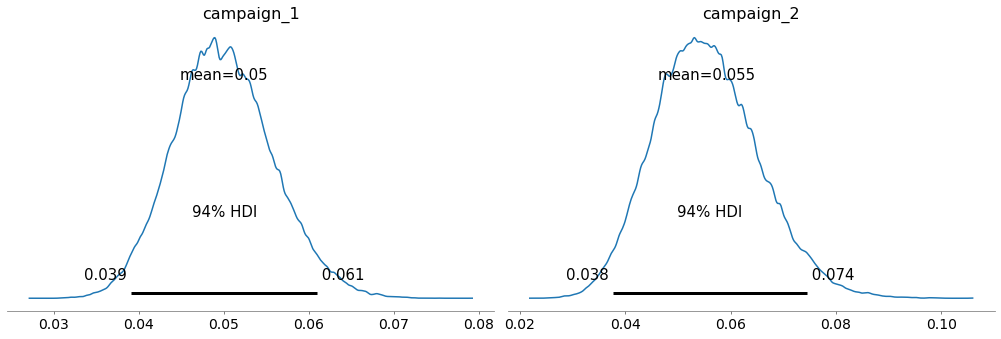

In [3]:
test_2 = create_bayesian_ab_test_model(
    'campaign_1', 1399, 69,
    'campaign_2', 540, 29
)

In [30]:
print_credible_intervals(test_2, 'campaign_1', 'campaign_2')

90% CI for campaign_1: (0.04074855521048817, 0.05993758717697821)
90% CI for campaign_2: (0.04018733522466373, 0.07250230452302502)


/var/folders/1r/_qv5n71d6133d56_rx4zzq580000gn/T/ipykernel_12707/110112713.py:16: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(100000, step=step)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [Derek Jeter]
>Metropolis: [Scott Brosius]


Sampling 4 chains for 1_000 tune and 100_000 draw iterations (4_000 + 400_000 draws total) took 61 seconds.
The number of effective samples is smaller than 25% for some parameters.


Probability that Derek Jeter is better: 100.0.


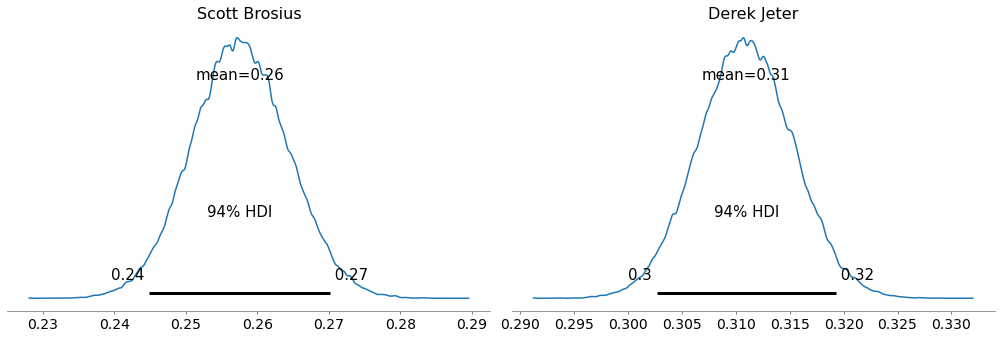

In [26]:
# http://varianceexplained.org/r/credible_intervals_baseball/
test_baseball = create_bayesian_ab_test_model(
    'Scott Brosius', 3889, 1001,
    'Derek Jeter', 10614, 3316,
    prior_alpha=78.661, prior_beta=224.875
)

In [31]:
print_credible_intervals(test_baseball, 'Scott Brosius', 'Derek Jeter', interval=95)

95% CI for Scott Brosius: (0.2445121867625697, 0.27093197733268737)
95% CI for Derek Jeter: (0.3023046867632912, 0.3196182007100119)
